# Sustainable energy companies and its comparison to standard ones

##  Data analysis and visualisation part
In this module, user insterts the timeframe that he want to observe and also can create two portfolios, that will be analyzed and compared, the portfolios will be created by specifing codes of stocks and than downloaded from yahoo finance

In [1]:
#popisná statistika - datasetů, vizualizace, vytvoření portfolia + analýza
# Import packages
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import datetime as dt
import yfinance as yf
import seaborn as sns
import functools as reduce
from scipy import optimize

## Portfolio Selection Functions

### Auxiliary Functions

In [38]:
# Portfolio standard deviation
def standard_deviation(weights: np.array, cov_matrix: np.array) -> float:
    """Calculates the standard deviation of the portfolio"""
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Expected return
def neg_expected_return(weights: np.array, log_returns: np.array) -> float:
    """Calculates the annulazied Expected return of the portfolio
    as a simple mean of the returns on specified assets"""
    return -np.sum(log_returns.mean()*weights)*252

# Sharpe Ratio
def neg_sharpe_ratio(weights: np.array, log_returns: np.array, cov_matrix: np.array, risk_free_rate: float) -> float:
    """Calculates the negative sharpe ratio of the portfolio"""
    return (neg_expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

### Optimization of Weights

In [39]:
def optimize_portfolio(adj_close_data: pd.DataFrame , min_weight: float,
                       max_weight: float, method: str, rf_rate: float = 0.02):
    """Takes in data on adjusted close prices of specified assets, minimum and maximum
    proportion of one asset in the portfolio, preferred portfolio selection method, either min_variance,
    max_exp_return or max_sharpe, and returns an object containing optimized weights of the portfolio."""
    
    # Log returns extraction
    log_returns = np.log(adj_close_data / adj_close_data.shift(1)).dropna()
    
    # Annualized covariance matrix
    cov_matrix = log_returns.cov() * 252
    
    # calculate variables for optimization
    init_weights = np.array([1/log_returns.shape[1]]*log_returns.shape[1])
    df_std_dev = standard_deviation(init_weights, cov_matrix)
    df_exp_return = -neg_expected_return(init_weights, log_returns = log_returns)
    df_sharpe = neg_sharpe_ratio(init_weights, log_returns, cov_matrix, rf_rate)
    
    # Set optimization constraints
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    bounds = [(min_weight, max_weight) for _ in range(log_returns.shape[1])]
    
    if method == "max_sharpe":
    # minimize negative sharpe ratio
        optimized_results = optimize.minimize(neg_sharpe_ratio, init_weights,
                    args=(log_returns, cov_matrix, rf_rate), method='SLSQP', constraints=constraints, bounds=bounds)
        
    if method == "min_variance":
        optimized_results = optimize.minimize(
        standard_deviation, init_weights,
        args=(cov_matrix), method='SLSQP', constraints=constraints, bounds=bounds)
        
    if method == "max_exp_return":
        optimized_results = optimize.minimize(neg_expected_return, init_weights,
        args=(log_returns), method='SLSQP', constraints=constraints, bounds=bounds)

    return optimized_results

## Functions for performing exploratory analysis

In [29]:
def analyze_dataset(df, summary_stat=False, data_quality=False, exploratory_analysis=False):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The provided input is not appropriate DataFrame.")

    # Summary Statistics
    if summary_stat: 
        print("Shape of the DataFrame:", df.shape)
        print("First 5 rows of the DataFrame:")
        print(df.head(5))
        print("DataFrame Info:")
        print(df.info())
        print("Descriptive Statistics:")
        print(df.describe())

    # Data Quality Check
    if data_quality:
        print("Number of missing values in each column:")
        print(df.isna().sum())
        print("Duplicate rows in the DataFrame:")
        print(df[df.duplicated()])

    # Exploratory Analysis
    if exploratory_analysis:
        # Graph of Stocks
        plt.figure(figsize=(15, 6))
        for column in df.columns:
            plt.plot(df.index, df[column], label=column)
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.title('Selected Asset Values Over Time')
        plt.legend()
        plt.show()

        # Each Stock Alone
        ncols = 4
        nrows = int(np.ceil(len(df.columns) / ncols))
    
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
        axes = axes.flatten()
        for i, column in enumerate(df.columns):
            axes[i].plot(df.index, df[column])
            axes[i].set_title(column, fontsize=10)
            axes[i].set_xlabel('Date', fontsize=8)
            axes[i].set_ylabel('Value', fontsize=8)
            axes[i].tick_params(axis='x', labelrotation=45)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.tight_layout(pad=3.0)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.show()

        # Box Plot Distribution Analysis
        print("Box plot for distribution analysis")
        ax = df.plot(kind='box')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.tick_params(axis='x', labelsize=8)
        plt.show()

        # Heatmap for Correlation Between Assets
        print("Heatmap for Correlation Between Assets")
        correlation_matrix = df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True)
        plt.tight_layout()
        plt.show()


## Loading the Data 

- to see detatiled info on data that we use, see documentation
- We will take some of the biggest renewable Energy Companies in the World and create on portfolio from them
- And we will also take some of the largest energy companies that do not focus maily on sustainable resouces
- more details: frequency: daily, historical prices, time period: last 5Y

In [5]:
# delete
# Stocks/Tickers we want to analyze
#first_dataset= ["AQN", "BEPC", "CEG", "CSIQ", "DQ", "GE", "IBDRY", "JKS", "NEE", "VWDRY"]
# Get Adjusted Close prices
#sustainable = get_stock_data(tickers = first_dataset, num_days_back = 1000, info_type = "Adj Close")

### Processing user input

Sustainable stocks: AQN,BEPC,CEG,CSIQ,DQ,GE,IBDRY,JKS,NEE,VWDRY

Unsustainable stocks: EQNR,BP,0857.HK,COP,FP.VI,SHEL,CVX,SR,ENEL.MI

In [6]:
# Specify the tickers :
user_input_str = input("Enter a list of tickers you want to analyze, separated by a comma only: ")

user_input_list = user_input_str.split(',')

# Remove leading and trailing whitespaces from each string in the list
tickers = [item.strip() for item in user_input_list]

# create the adjusted close price dataframe
adj_close_df = pd.DataFrame()

# populate the dataframe with adjusted close price data of specified assets
for ticker in tickers:
    data = yf.download(ticker, period = "1y", interval = "1d")
    adj_close_df[ticker] = data["Adj Close"]

Enter a list of tickers you want to analyze, separated by a comma only:  EQNR,BP,0857.HK,COP,FP.VI,SHEL,CVX,SR,ENEL.MI


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of the DataFrame: (251, 9)
First 5 rows of the DataFrame:
                 EQNR         BP   0857.HK         COP      FP.VI       SHEL  \
Date                                                                           
2023-02-06  26.473776  33.309891  3.748759  103.675880  53.801762  55.610245   
2023-02-07  26.831160  36.092091  3.776391  108.045135  53.877766  57.302109   
2023-02-08  28.737198  36.952564  3.794812  106.858788  54.504799  57.167530   
2023-02-09  29.039600  37.813034  3.794812  106.029289  54.628311  57.475136   
2023-02-10  30.267527  38.864727  3.776391  110.977272  54.989330  59.368862   

                   CVX         SR   ENEL.MI  
Date                                         
2023-02-06  163.226685  71.869629  5.041094  
2023-02-07  167.508438  71.133842  5.022350  
2023-02-08  163.573074  69.442444  5.010167  
2023-02-09  162.072037  68.496414  5.004544  
2023-02-10  165.468582  69.538002  5.071084  
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>

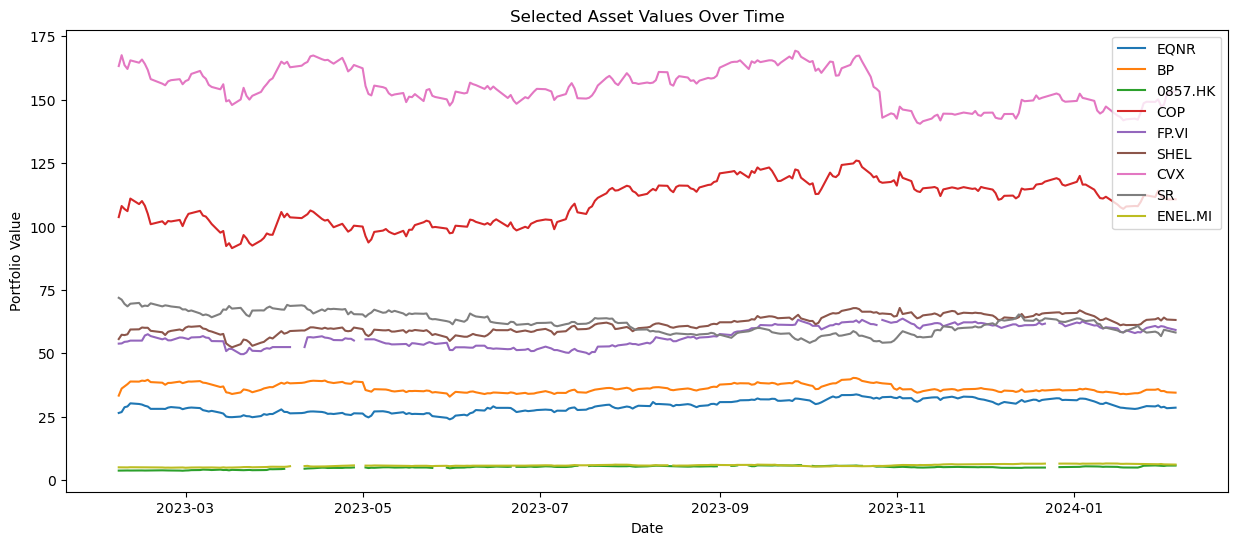

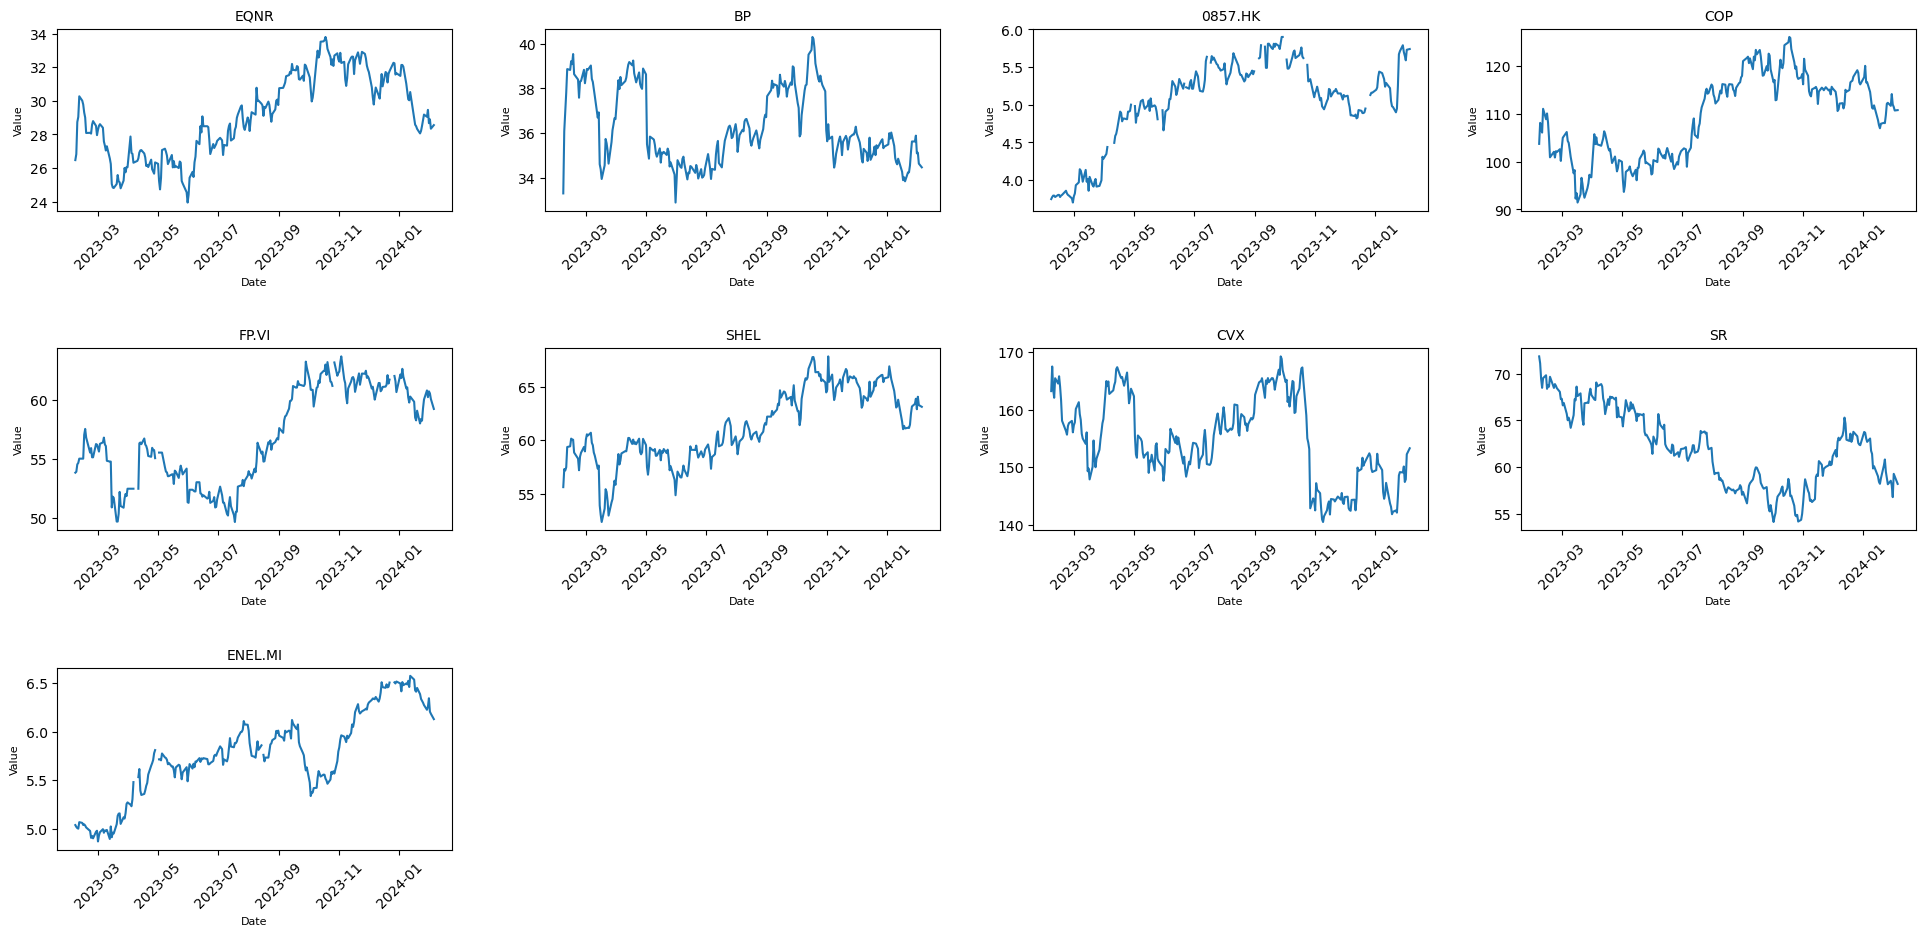

Box plot for distribution analysis


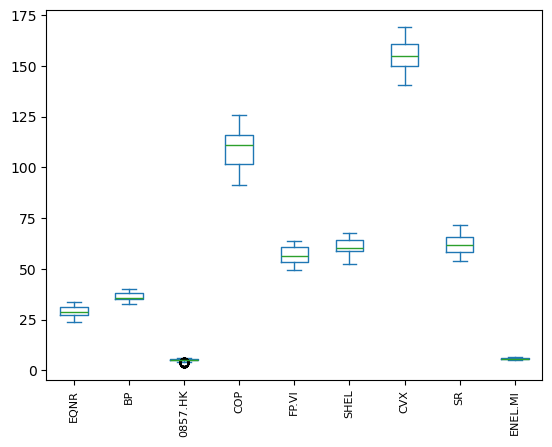

Heatmap for Correlation Between Assets


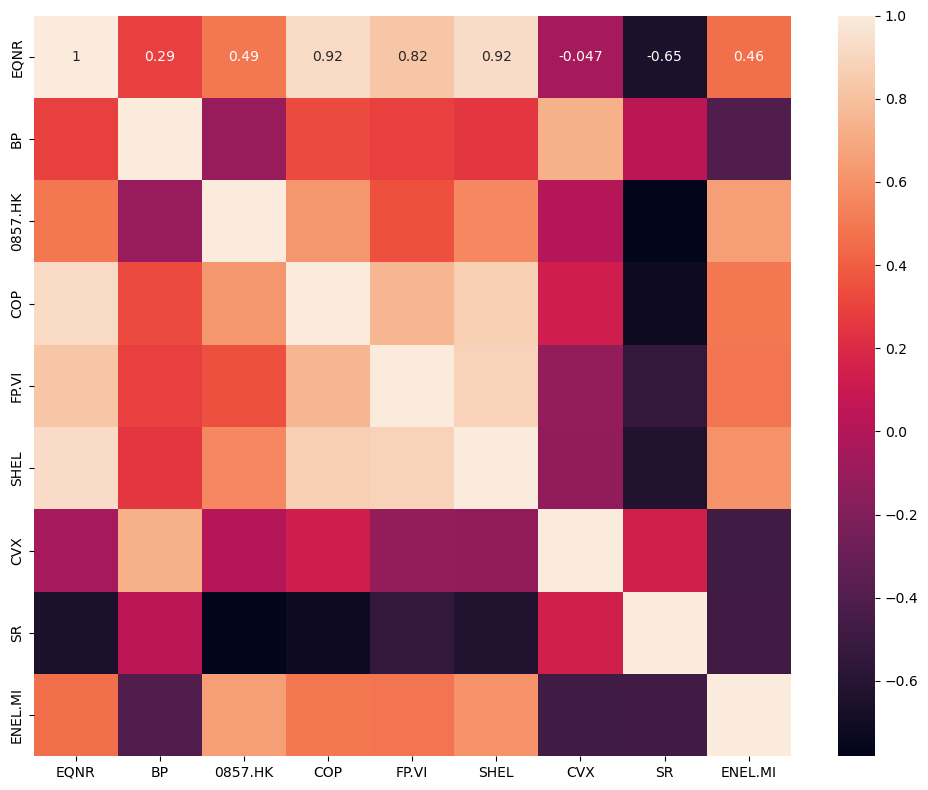

In [19]:
# Primary analysis
analyze_dataset(adj_close_df, summary_stat= True, data_quality = True, exploratory_analysis= True)

## Portfolio analysis

In [23]:
invested_amount = float(input("Enter amount to invest: "))

Enter amount to invest:  1000


#### Optimal weights of assets

Maxmimum Expected Return Method:
Expected Annual Return: 0.2759
Expected Volatility: 0.1780
Sharpe Ratio: 1.6619
Minimum Variance Method:
Expected Annual Return: 0.1633
Expected Volatility: 0.1242
Sharpe Ratio: 1.4762
Maximum Sharpe Ratio Method:
Expected Annual Return: 0.2567
Expected Volatility: 0.1442
Sharpe Ratio: 1.9197


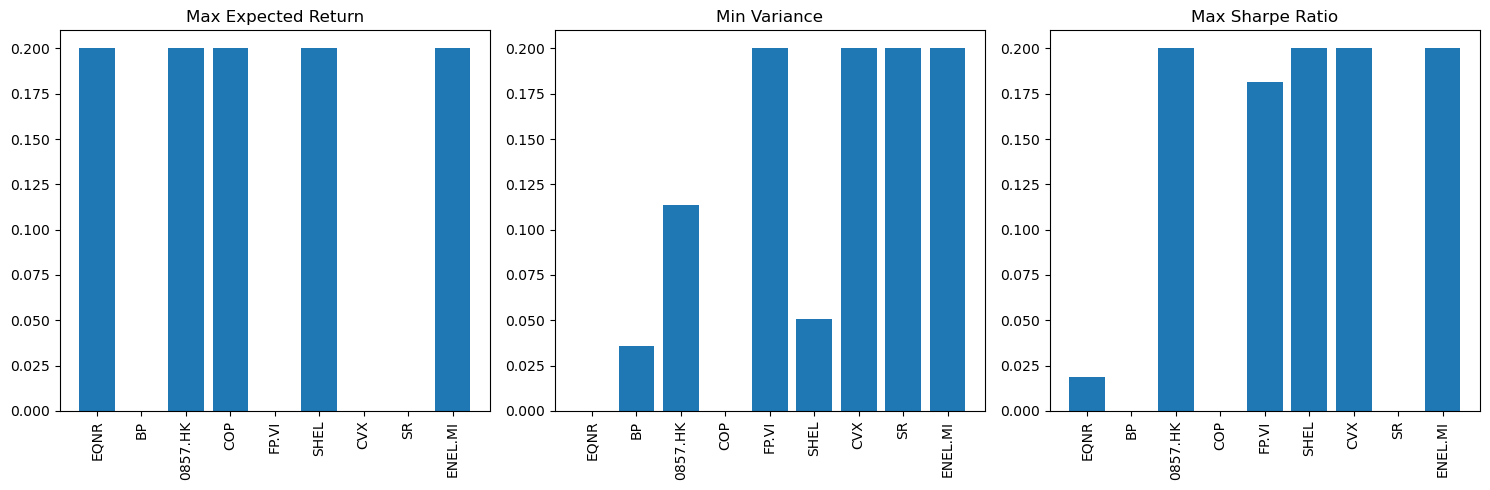

In [40]:
# Auxiliary variables for analysis
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()
cov_matrix = log_returns.cov() * 252

# Optimal portfolio information for max_exp_return
optimal_result_max_exp_return = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="max_exp_return")
optimal_weights_max_exp_return = optimal_result_max_exp_return.x

# Optimal portfolio information for min_variance
optimal_result_min_variance = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="min_variance")
optimal_weights_min_variance = optimal_result_min_variance.x

# Optimal portfolio information for max_sharpe
optimal_result_max_sharpe = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="max_sharpe")
optimal_weights_max_sharpe = optimal_result_max_sharpe.x

# variance, expected return and Sharpe Ratio for each method

# Max. Expected return
max_exp_return = -neg_expected_return(optimal_weights_max_exp_return, log_returns = log_returns)
max_exp_volatility = standard_deviation(optimal_weights_max_exp_return, cov_matrix)
max_exp_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_max_exp_return, log_returns, cov_matrix, 0.02)

# Min. Variance
min_vol_return = -neg_expected_return(optimal_weights_min_variance, log_returns = log_returns)
min_vol_volatility = standard_deviation(optimal_weights_min_variance, cov_matrix)
min_vol_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_min_variance, log_returns, cov_matrix, 0.02)

# Max. Sharpe Ratio
max_sharpe_return = -neg_expected_return(optimal_weights_max_sharpe, log_returns = log_returns)
max_sharpe_vol = standard_deviation(optimal_weights_max_sharpe, cov_matrix)
max_sharpe_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_max_sharpe, log_returns, cov_matrix, 0.02)

# show the portfolio information for each:
print("Maxmimum Expected Return Method:")
print(f"Expected Annual Return: {max_exp_return:.4f}")
print(f"Expected Volatility: {max_exp_volatility:.4f}")
print(f"Sharpe Ratio: {max_exp_sharpe:.4f}")

print("Minimum Variance Method:")
print(f"Expected Annual Return: {min_vol_return:.4f}")
print(f"Expected Volatility: {min_vol_volatility:.4f}")
print(f"Sharpe Ratio: {min_vol_sharpe:.4f}")

print("Maximum Sharpe Ratio Method:")
print(f"Expected Annual Return: {max_sharpe_return:.4f}")
print(f"Expected Volatility: {max_sharpe_vol:.4f}")
print(f"Sharpe Ratio: {max_sharpe_sharpe:.4f}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for max_exp_return
axs[0].bar(tickers, optimal_weights_max_exp_return)
axs[0].set_title('Max Expected Return')
axs[0].tick_params(axis='x', rotation=90)

# Plot for min_variance
axs[1].bar(tickers, optimal_weights_min_variance)
axs[1].set_title('Min Variance')
axs[1].tick_params(axis='x', rotation=90)

# Plot for max_sharpe
axs[2].bar(tickers, optimal_weights_max_sharpe)
axs[2].set_title('Max Sharpe Ratio')
axs[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

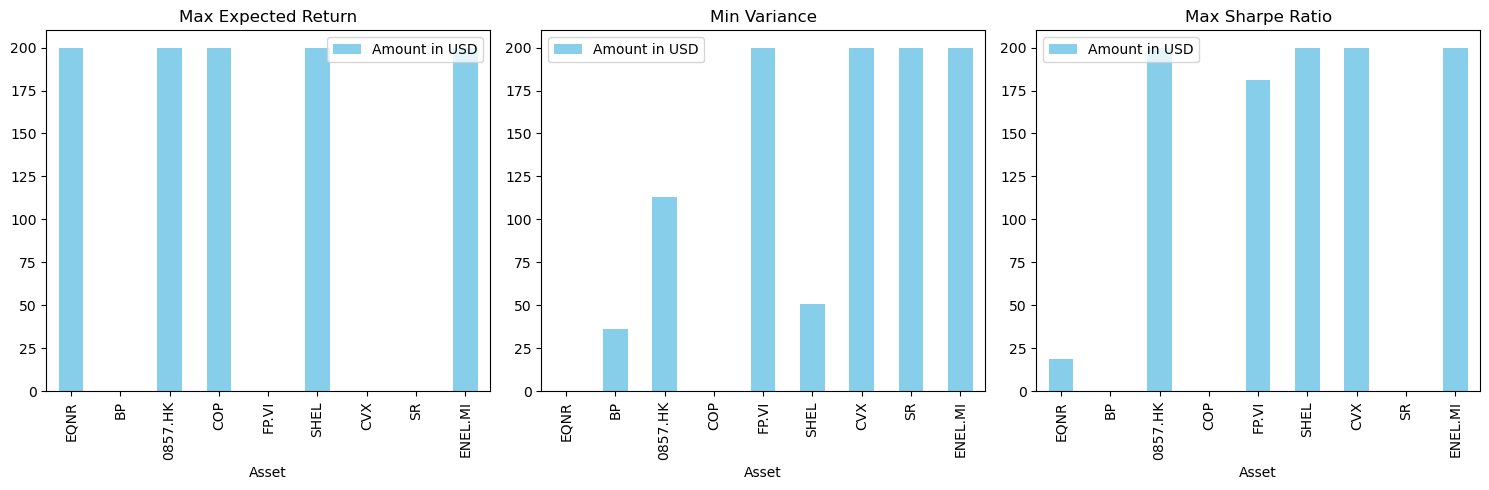

In [45]:
# Portfolio dataframe for max_exp
positions_max_exp = np.round(optimal_result_max_exp_return.x*float(invested_amount))
portfolio_max_exp = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_max_exp})

# Portfolio dataframe for min_variance
positions_min_variance = np.round(optimal_result_min_variance.x * float(invested_amount))
portfolio_min_variance = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_min_variance})

# Portfolio dataframe for max_sharpe
positions_max_sharpe = np.round(optimal_result_max_sharpe.x * float(invested_amount))
portfolio_max_sharpe = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_max_sharpe})

# Displaying portfolio breakdowns side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot for max_exp_return
portfolio.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title('Max Expected Return')

# Plot for min_variance
portfolio_min_variance.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[1])
axs[1].set_title('Min Variance')

# Plot for max_sharpe
portfolio_max_sharpe.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[2])
axs[2].set_title('Max Sharpe Ratio')

# Adjust layout
plt.tight_layout()

plt.show()

In [26]:
# Portfolio value over time -> to be created
# Set the size of the plot
plt.figure(figsize=(15, 6))

# Plotting the summed data
plt.plot(portfolio_df.index, portfolio_df, label='Total Portfolio Value', color="blue")

# Customizing the graph
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Total Portfolio Value Over Time')
plt.legend()

# Displaying the plot
plt.show()

NameError: name 'portfolio_df' is not defined

<Figure size 1500x600 with 0 Axes>

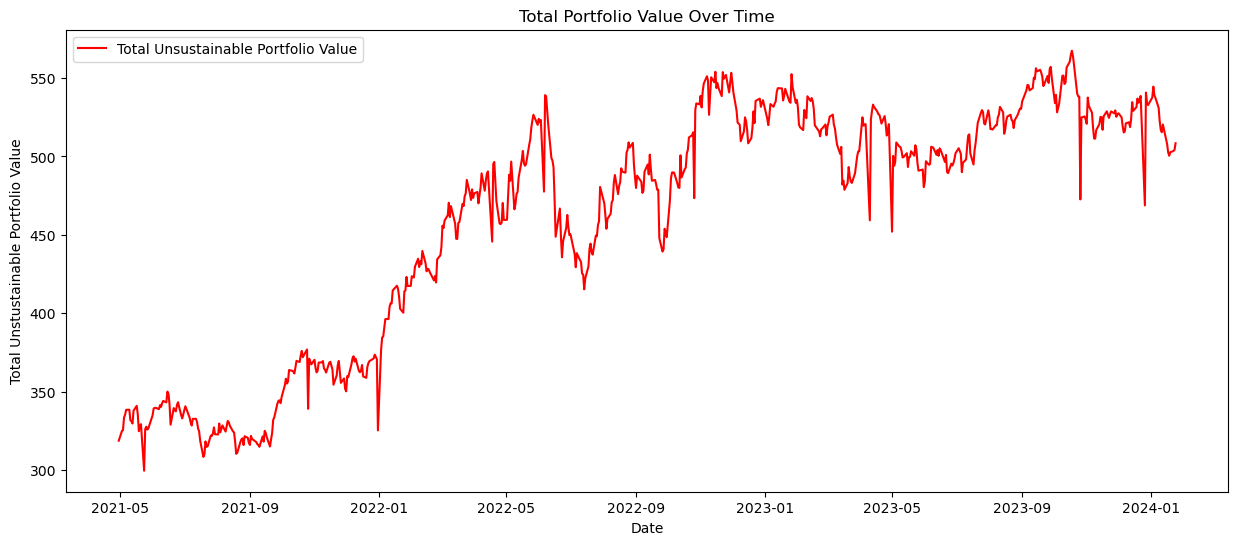

In [32]:
# Stotal portfolio
total_un_portfolio = df_unsustain.sum(axis=1)

# Set the size of the plot
plt.figure(figsize=(15, 6))

# Plotting the summed data
plt.plot(total_un_portfolio.index, total_un_portfolio, label='Total Unsustainable Portfolio Value', color="red")

# Customizing the graph
plt.xlabel('Date')
plt.ylabel('Total Unstustainable Portfolio Value')
plt.title('Total Portfolio Value Over Time')
plt.legend()

# Displaying the plot
plt.show()

#### Combination of both portfolios

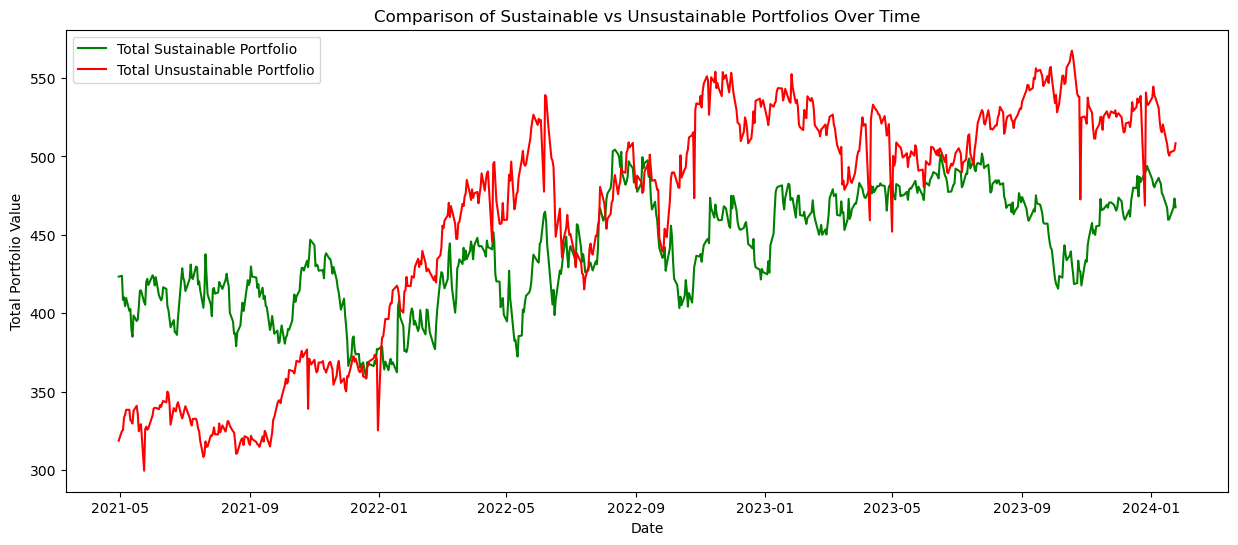

In [34]:
# Summing the data across columns for both DataFrames
total_sustain = df_sustain.sum(axis=1)
total_unsustain = df_unsustain.sum(axis=1)

# Set the size of the plot
plt.figure(figsize=(15, 6))

# Plotting the summed data for both DataFrames
plt.plot(total_sustain.index, total_sustain, label='Total Sustainable Portfolio', color='green')
plt.plot(total_unsustain.index, total_unsustain, label='Total Unsustainable Portfolio', color='red')

# Customizing the graph
plt.xlabel('Date')
plt.ylabel('Total Portfolio Value')
plt.title('Comparison of Sustainable vs Unsustainable Portfolios Over Time')
plt.legend()

# Displaying the plot
plt.show()

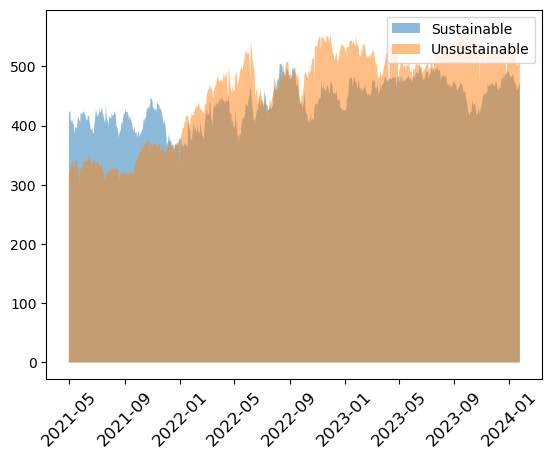

In [42]:
#An area plot can be used to display the cumulative values over time, showing how each portfolio's total value grows.
#This can be particularly effective in highlighting the growth difference between the two portfolios.

plt.fill_between(total_sustain.index, total_sustain, label='Sustainable', alpha=0.5)
plt.fill_between(total_unsustain.index, total_unsustain, label='Unsustainable', alpha=0.5)

# Improving the X-axis labels
plt.xticks(rotation=45)  # Rotate labels by 45 degrees
plt.tick_params(axis='x', labelsize=12)  # Decrease font size of labels 
# Displaying the plot
plt.legend()
plt.show()


In [44]:
# Bar Chart for Comparing Specific Intervals
monthly_sustain = df_sustain.resample('M').mean()
monthly_unsustain = df_unsustain.resample('M').mean()


<Axes: xlabel='Date'>

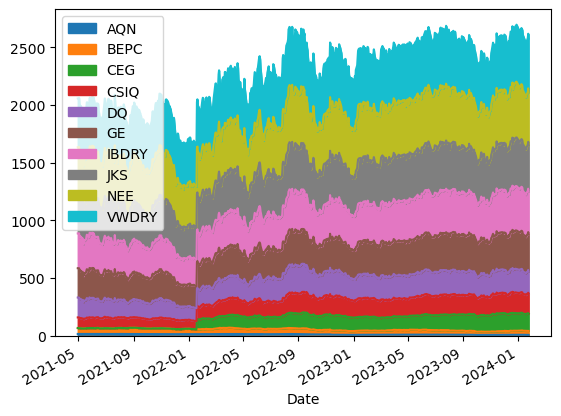

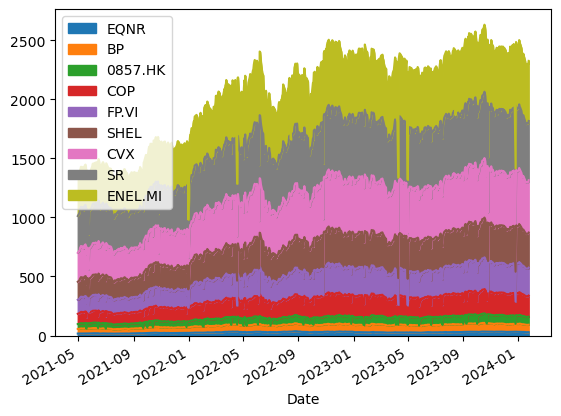

In [53]:
# Stacked Line or Area Chart for Portfolio Composition
df_sustain.cumsum(axis=1).plot(kind='area')
df_unsustain.cumsum(axis=1).plot(kind='area')
